In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np


In [2]:
# dataset = pd.read_pickle('../../geodata/results/01_master_building_dataset.pkl')
dataset = pd.read_pickle('../../../geodata/results/01_master_building_dataset.pkl')

maxvsh_cols    = dataset.columns[dataset.columns.str.contains('maxvsh')].tolist()
vaccess_cols   = dataset.columns[dataset.columns.str.contains('vwa')].tolist()
# mean_cols      = dataset.columns[dataset.columns.str.contains('mn')].tolist()
dist_cols      = dataset.columns[dataset.columns.str.contains('sum_')].tolist()
vconfig_cols   = np.setdiff1d(dataset.columns[np.where(dataset.columns == 'snt_0')[0][0]:np.where(dataset.columns == 'cmpx_gini')[0][0]+1].tolist(),dist_cols).tolist()
id_cols        = ['ID_Geb','Stockwerk','FassPktX','FassPktY','FassPktZ']

dataset['unit_pano'] = dataset['unit_pano'].fillna(0)



In [3]:
import joblib
xgb_model   = joblib.load("../../../geodata/results/t10agglo_models/tr292ts73_XGB.joblib")
model_feats    = maxvsh_cols+vaccess_cols+vconfig_cols+dist_cols

scaler_4model   = joblib.load("../../../geodata/results/scaler_for_model.joblib")

X = dataset.copy()
X[model_feats] = scaler_4model.transform(dataset[model_feats])

X['XGB'] = xgb_model.predict(X[xgb_model.feature_names_in_])
X = X.reset_index()


[23:22:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



/Users/adamswietek/opt/anaconda3/envs/env_intel_sdb/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
ch_terrainslope = gpd.read_file('../../../geodata/ch_terrain/ch_slope_2056.gpkg')
ch_terrainslope = ch_terrainslope.dropna()

<Axes: >

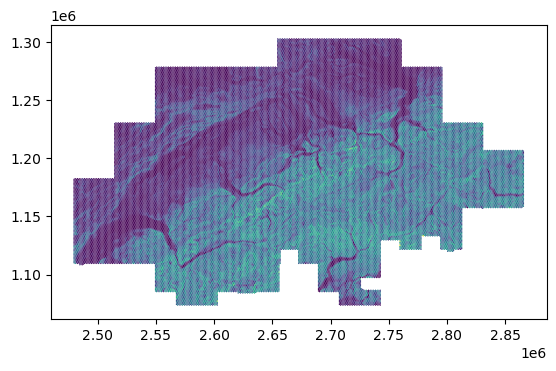

In [5]:
ch_terrainslope.plot('_mean', edgecolor = 'none')

In [6]:
#get average neighbor value
%time buffered = X.buffer(1000, cap_style=3)
%time buff_idx, pt_idx = X.geometry.sindex.query_bulk(buffered, predicate="contains")
%time latent = np.take(X.XGB, pt_idx, axis=0)
%time group = pd.DataFrame(latent).groupby(buff_idx)
%time nabr = group.mean()
X['avg_nabr_pred'] = nabr.XGB
X['num_nabr'] = group.size()

CPU times: user 34.7 s, sys: 794 ms, total: 35.5 s
Wall time: 35.7 s


In [ ]:
#get average slope wrt to each building
%time buffered = XX.buffer(1000, cap_style=3)
%time buff_idx, pt_idx = ch_terrainslope.geometry.sindex.query_bulk(buffered)
%time latent = np.take(ch_terrainslope._mean, pt_idx, axis=0)
%time group = pd.DataFrame(latent).groupby(buff_idx)
%time nabr = group.mean()
X['avg_slope'] = nabr._mean
X['num_slope'] = group.size()

CPU times: user 110 ms, sys: 12.8 ms, total: 123 ms
Wall time: 147 ms
CPU times: user 30.8 ms, sys: 16.2 ms, total: 46.9 ms
Wall time: 58.6 ms
CPU times: user 1.06 ms, sys: 218 µs, total: 1.28 ms
Wall time: 1.28 ms
CPU times: user 498 µs, sys: 9.73 ms, total: 10.2 ms
Wall time: 10.3 ms
CPU times: user 2.22 ms, sys: 743 µs, total: 2.97 ms
Wall time: 2.97 ms


In [ ]:
df = pd.read_pickle('../../../geodata/results/02_spatial_binned_master.pkl')

In [ ]:
X.to_pickle('../../../geodata/results/03_spatial_lagged_master.pkl')